In [37]:
#Bring in excel file
import pandas as pd
import numpy as np
import matplotlib

#Parse into dataframe
xl = pd.ExcelFile('Capstone_Project_1.xlsx')

#Skip blank rows, parse first sheet
Wells_DF = xl.parse("CA DOGGR Wells",skiprows=3, index_col=None)

#Filter on OG
Wells_DF= Wells_DF[Wells_DF['Pool WellTypes'].str.contains('OG', na= False)]

#Split on comma
Wells_DF['Field Name'] = Wells_DF['Field Name'].str.split(',').str[0]

#Convert Spud Date from object to date
#Wells_DF['SPUD Date'].convert_objects(convert_dates=True)

Wells_DF['SPUD Date'] = pd.to_datetime(Wells_DF['SPUD Date'])
Wells_DF['Year'] = Wells_DF['SPUD Date'].dt.year

In [25]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")

sns.set_context("poster")

In [70]:
#Bringing in Oil Price df
Oil_Price = xl.parse("Crude Oil Price",skiprows=2, index_col=None)
Oil_Price['Year'] = Oil_Price['Date'].dt.year

df_merge=Wells_DF.merge(Oil_Price,how='left',on='Year')
df_merge = df_merge[['Field Name', 'Directional', 'Year', 'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)']]
df_merge.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)': 'Oil Price'}, inplace=True)
df_merge.fillna(method='ffill')
df_merge = df_merge[np.isfinite(df_merge['Oil Price'])]
df_merge['Directional'] = df_merge['Directional'].replace('Y', 1)
df_merge['Directional'] = df_merge['Directional'].replace('N', 0)
df_merge

,Field Name,Directional,Year,Oil Price
1,Cymric,0,1992,18.79
2,Cymric,0,1992,19.01
3,Cymric,0,1992,18.92
4,Cymric,0,1992,20.23
5,Cymric,0,1992,20.98
6,Cymric,0,1992,22.39
7,Cymric,0,1992,21.78
8,Cymric,0,1992,21.34
9,Cymric,0,1992,21.88
10,Cymric,0,1992,21.69


In [73]:
# Classification tries to predict, which of a small set of classes, an observation belongs to. Mathematically, the aim is to find  yy , a label based on knowing a feature vector  xx .


#Uses labels of oil price and whether the well was directionally drilled to determine field it came from. 
#Some fields are more likely to keep drilling and are not as price senstive (such as Kern River)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(df_merge[['Oil Price','Directional']].values, 
                                              (df_merge['Field Name'] == "Kern River").values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

0.870439331978


In [78]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print("Accuracy score:",score)

Accuracy score: 0.869423501637


In [85]:
#Clustering

import numpy as np
from scipy.spatial.distance import cdist, pdist
# your turn
#you want to reduce the amount of error between each point (this represents a good cluster). so anythiing as close to 0 as posssible

x_cols = df_merge.as_matrix(columns=df_merge.columns[1:])



for k in range(1,11):
    cluster = k_means(x_cols, n_clusters = k)   
    centroids = cluster[0]
    labels = cluster[1]
    inertia = cluster[2]

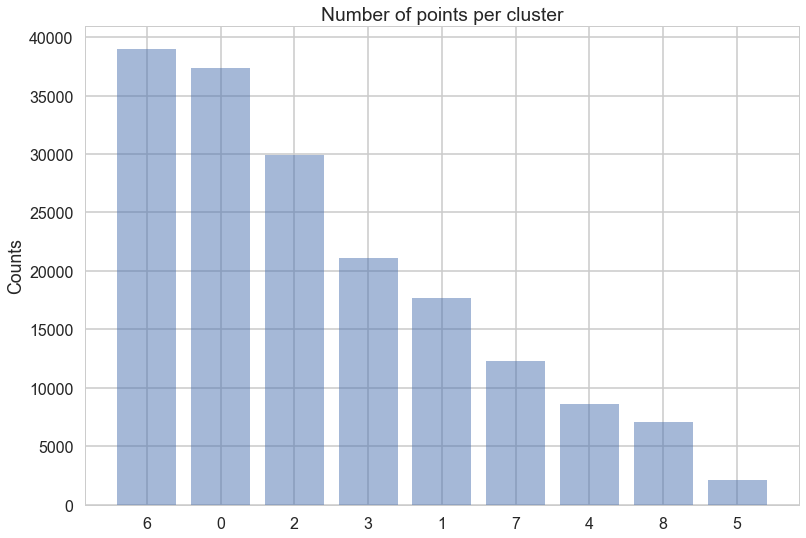

In [86]:
#Understanding how many points there are based on the cluster


from sklearn.cluster import k_means
# setup KMEans for cluster = 9
cluster = k_means(x_cols,n_clusters=9)

# predict and assign to a cluster
newdf = pd.DataFrame(columns = ['cluster'])
newdf['cluster'] = cluster[1]
y = newdf.cluster.value_counts()


# index number is the cluster number
cluster = y.index.values
x_lim = np.arange(len(y))

# plot bar chart
plt.bar(x_lim, y, align='center', alpha=0.5)
plt.xticks(x_lim, cluster)
plt.ylabel('Counts')
plt.title('Number of points per cluster')
 
plt.show()